# Convert an Image into MIDI notes
This notebook converts the pixel data of an image into musical notes as was done in Saturn's B Ring, for Harp and Drums (https://youtu.be/VUZXl4tpabs). The user chooses a jpg file, a set of notes, a range of note velocities (volume,intensity), a tempo, and the rhythmic subdivision (ex. 16th notes). 

### Load an image, plot the pixel values along the middle row


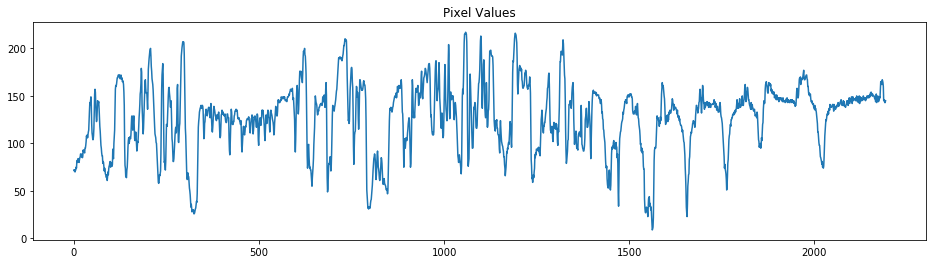

In [1]:
from PIL import Image
import numpy as np

filename='BRing'        #choose a jpg file to load
im = Image.open('./images/'+filename+'.jpg') 

#im.show()
Ncolumns, Nrows = im.size  #calculate the number of columns and rows in the image
grey_im = im.convert('L')  #convert color image to black and white

row=int(Nrows/2)  #choose middle row as default
pixels = [grey_im.getpixel((i,row)) for i in range(Ncolumns)]

#set buffer pixels to avoid image frame
buffL=1    #ignore first il pixels
buffR=6   #ignore last ir pixels
pixels=pixels[buffL:-buffR]
Npix=int(len(pixels))

import matplotlib.pyplot as plt
plt.figure(figsize=(16,4))
plt.plot(pixels)
plt.title('Pixel Values')
plt.show()

### Choose notes and velocity range 
The actual instrument sound is determined once the MIDI file is played in a Digitial-Audio Workstation (DAW) such as GarageBand or Logic.

In [2]:
instrumentName = 'harp'  #actual sound must be chosen after importing MIDI file into a DAW
noteStr=['C2', 'C3', 'G3', 'C4', 'E4', 'G4', 'A#4', 'C5', 'D5', 'E5', 'F#5', 'G5', 'G#5'] #first 13 notes of the harmonic series

vmin,vmax=30,120    #minimum and maximum note velocity(volume,intensity) 0-127 

# OR

### Choose 'notes' and velocity range for drum notes
Once again, the actual instrument sound is determined once the MIDI file is played in a DAW such as GarageBand or Logic, but the note choices here correspond to a standard drum kit for most DAW drum sets.

In [3]:
instrumentName = 'drums'
noteStr=['C2', 'D2', 'E2', 'F#2', 'G#2', 'A#2', 'G2', 'A2', 'C3', 'D#3', 'E3', 'C#3', 'A3'] #drum 'notes'
vmin,vmax=0,127    #minimum and maximum note velocity(volume,intensity) 0-127 

### Choose tempo and subdivision

In [4]:
bpm=137.0625      #choose tempo (beats per minute)
subDiv = 1./4     #choose subdivision (1/4: each pixel lasts for 1/4 of a beat, a 16th note)


# Convert to quantized pitches and plot results
This cell converts the pixel data into the notes and note velocites chosen earlier. You will need to install audiolazy by typing 'pip install audiolazy' into the command line. Alternatively, you could specify the list of MIDI notes directly (Ex. noteMidi=[36, 48,...]) and comment out the lines containing 'str2midi'. Here we use the pixel data to control the notes and the note velocity so that brighter pixels get mapped to higher and louder notes.

bpm = 137.0625, subdivision = 0.25, duration = 240.0 seconds


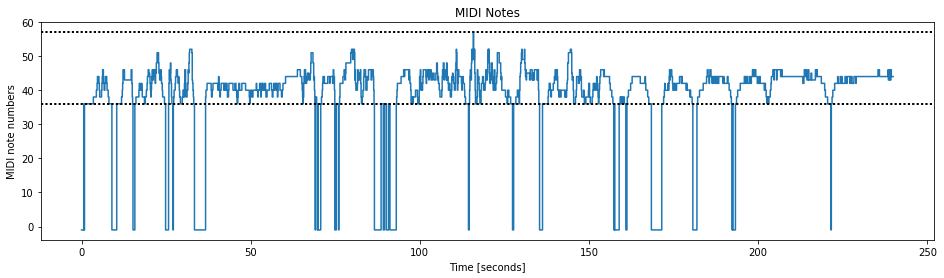

In [5]:
def data2notes(yi):
    '''converts normalized y data to quantized midi notes'''
    if yi>ymin:
        data_note_i=int((yi-ymin)/(1.-ymin)*(Nnotes-1))
        return noteMidi[data_note_i]
    else:
        return -1 #note will not be recorded
def data2vels(yi):
    '''converts normalized y data to quantized note velocities'''
    if yi>ymin:
        data_vels = int(vmin + (yi-ymin)/(1.-ymin)*(vmax-vmin))
        return data_vels
    else:
        return -1  #note will not be recorded
    
from audiolazy import str2midi  #http://pythonhosted.org/audiolazy/lazy_midi.html

noteMidi=[str2midi(n) for n in noteStr] #or set the MIDI note numbers manually as noteMidi=[36, 48,...]
Nnotes=len(noteMidi)

nBeats = Npix*subDiv       #calculate total numbver of beats
duration = nBeats/bpm*60.  #calculate total duration in seconds
print('bpm = {0}, subdivision = {1}, duration = {2} seconds'.format(bpm,subDiv,duration))

time = np.array(range(Npix))*subDiv       #make time axis in units of beats
yShift = np.array(pixels)-np.min(pixels)  #shift so that the lowest note has y=0
scale=2.           #set >1 to increase contrast
yScale = np.array(yShift)**scale          #scale>1 to increase note contrast if desired
y = yScale/np.max(yScale)                 #normalize data so that highest note has y=1
ymin=0.1           #minimum value to count as note, allows silence for the darkest pixels


y_notes = [data2notes(yi) for yi in y]
y_vel = [data2vels(yi) for yi in y]  

#or set to a fixed velocity with 
#fixedvel=100
#y_vel=fixedVel*np.ones(len(y_norm))

plt.figure(figsize=(16,4))
plt.step(time/bpm*60,y_notes,where='post')
plt.axhline(y=min(noteMidi), linewidth=2, color = 'k',linestyle=':')
plt.axhline(y=max(noteMidi), linewidth=2, color = 'k',linestyle=':')
plt.title('MIDI Notes')
plt.xlabel('Time [seconds]')
plt.ylabel('MIDI note numbers')
plt.show()

# Write MIDI File

In [6]:
from midiutil import MIDIFile

midifile = MIDIFile(adjust_origin=True)
midifile.addTempo(track=0, time=time[0], tempo=bpm)    

for i,ti in enumerate(time):
    if y_notes[i]>0:
        midifile.addNote(track=0, channel=0, pitch=y_notes[i], time=ti, duration=subDiv, volume=y_vel[i])

with open("./"+filename+"_"+instrumentName+".mid", "wb") as f:
    midifile.writeFile(f)